# import statements

In [1]:
import logging
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


def setup_logging() -> None:
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(funcName)s | %(message)s',
        handlers=[
            logging.FileHandler('77-ipynb.log')
        ]
    )

    logging.info('Logging setup complete.')


def fetch_df(file_path: str) -> pd.DataFrame:
    logging.info('Initiating reading csv')
    
    try:
        in_df = pd.read_csv(file_path)
    except FileNotFoundError as notfound_err:
        logging.error(f'File not found at: {file_path}. Error: {notfound_err}')
        raise notfound_err
    except pd.errors.EmptyDataError as empty_err:
        logging.error(f'File empty: {empty_err}')
        raise empty_err
    except pd.errors.ParserError as parse_err:
        logging.error(f'Parse error: {parse_err}')
        raise parse_err
    except Exception as err:
        logging.error(f'Unexpected error: {err}')
        raise err
    else:
        logging.info(f'Dataframe loaded successfully from {file_path}')
        pd.options.display.float_format = '{:,.2f}'.format
        return in_df

# Explore and Clean the Dataset

In [2]:
def explore_df(in_df: pd.DataFrame) -> None:
    print(f'Dataframe shape: {in_df.shape}')

    print(f'Column names: {in_df.columns.to_list()}')
    print(f'Data types: {in_df.dtypes}')  

    print(f'NaN: {in_df.isna().values.any()}')
    print(f'NaN details:\n{in_df.isna().sum()}')


def explore_df_data(in_df: pd.DataFrame) -> None:
    print(f'Noble prize first awarded: {in_df.year.min()}')
    print(f'Noble prize latest awarded: {in_df.year.max()}')

    col_subset = ['year','category', 'laureate_type',
              'birth_date','full_name', 'organization_name']
    print(f'NaN Birth Rate:\n{in_df.loc[in_df.birth_date.isna()][col_subset]}')
    col_subset = ['year','category', 'laureate_type','full_name', 'organization_name']
    print(f'NaN Org Name:\n{in_df.loc[in_df.organization_name.isna()][col_subset]}')


def conv_df_dtype(in_df: pd.DataFrame) -> pd.DataFrame:
    in_df.birth_date = pd.to_datetime(in_df.birth_date, errors='coerce')

    share_parts = in_df.prize_share.str.split('/', expand=True)
    in_df['share_pct'] = pd.to_numeric(share_parts[0], errors='coerce') / pd.to_numeric(share_parts[1], errors='coerce')

    return in_df


# if __name__ == '__main__':
#     setup_logging()

#     in_df = fetch_df('input-79.csv')
#     explore_df(in_df)
#     explore_df_data(in_df)
#     in_df = conv_df_dtype(in_df)


# plotly Bar & Donut Charts: Analyse Prize Categories & Women Winning Prizes

In [3]:
def generate_gender_donut(in_df: pd.DataFrame) -> None:
    logging.info('Initiating donut figure generation')
    
    gender_count = in_df.sex.value_counts()
    donut_fig = px.pie(
        labels=gender_count.index,
        values=gender_count.values,
        names=gender_count.index,
        title='Nobel Prize by Gender',
        hole=0.5
    )
    donut_fig.update_traces(
        textposition='outside',
        textinfo='percent+label'
    )
    donut_fig.show()

    logging.info('Donut figure generation complete')


def explore_female_df(in_df: pd.DataFrame) -> None:
    female_df = in_df[in_df.sex == 'Female'].sort_values(by='year', ascending=True).reset_index(drop=True).copy()
    print(f'First three female nobel info:\n{female_df.head(3)}')

    print(f'Prize won for:\n{female_df.category.value_counts()}')

    print(f'First 3 female birth country and organization:\n{female_df[['birth_country', 'birth_country_current', 'organization_name']].head(3)}')


def multiple_nobel(in_df: pd.DataFrame) -> None:
    logging.info('Checking for multiple Nobel winners')

    # Get index of names that appear more than once
    multiple_winners = in_df[
        'full_name'
    ].value_counts().loc[
        lambda x: x > 1
    ].index

    if multiple_winners.empty:
        print('No multiple winners')
        return

    # Filter and display relevant details
    filtered_df = in_df.loc[
        in_df['full_name'].isin(multiple_winners), 
        [
            'year', 
            'category', 
            'laureate_type', 
            'full_name'
        ]
    ].sort_values(
        by=[
            'full_name', 
            'year'
        ]
    )

    print(f'Multiple Nobel Prize winners:\n{filtered_df.to_string(index=False)}')


def gen_category_bar(ind_df: pd.DataFrame) -> None:
    logging.info('Initiating Bar chart for categories')

    category_df = in_df.category.value_counts().reset_index()
    category_df.columns = ['Category', 'Count']


    # print(f'{category_df}')
    bar_fig = px.bar(
        data_frame=category_df,
        x='Category',
        y='Count',
        title='Nobel prize distribution by Category',
        labels={'Category': 'Category', 'Count': 'Nobel count'},
        color='Count',
        color_continuous_scale='Aggrnyl'
    )
    bar_fig.update_layout(coloraxis_showscale=False)
    bar_fig.show()


def gen_bar_gender_category(in_df: pd.DataFrame) -> None:
    cat_gender_df = in_df.groupby(
        ['category', 'sex'],
        as_index=False
    ).agg({'prize': 'count'}).sort_values(
        'prize',
        ascending=False
    )
    bar_fig = px.bar(
        data_frame=cat_gender_df,
        x='category',
        y='prize',
        color='sex',
        title='Category distribution by Gender',
        labels={'category': 'Nobel prize category', 'prize': 'Number of Prizes'}
    )
    bar_fig.show()
    

if __name__ == '__main__':
    setup_logging()

    in_df = fetch_df('input-79.csv')
    in_df = conv_df_dtype(in_df)

    # generate_gender_donut(in_df)
    
    # explore_female_df(in_df)

    # multiple_nobel(in_df)

    # gen_category_bar(in_df)

    # print(f'First economics award info:\n{in_df[in_df.category == 'Economics'].sort_values(by="year").iloc[0]}')

    gen_bar_gender_category(in_df)

# Using Matplotlib to Visualise Trends over Time

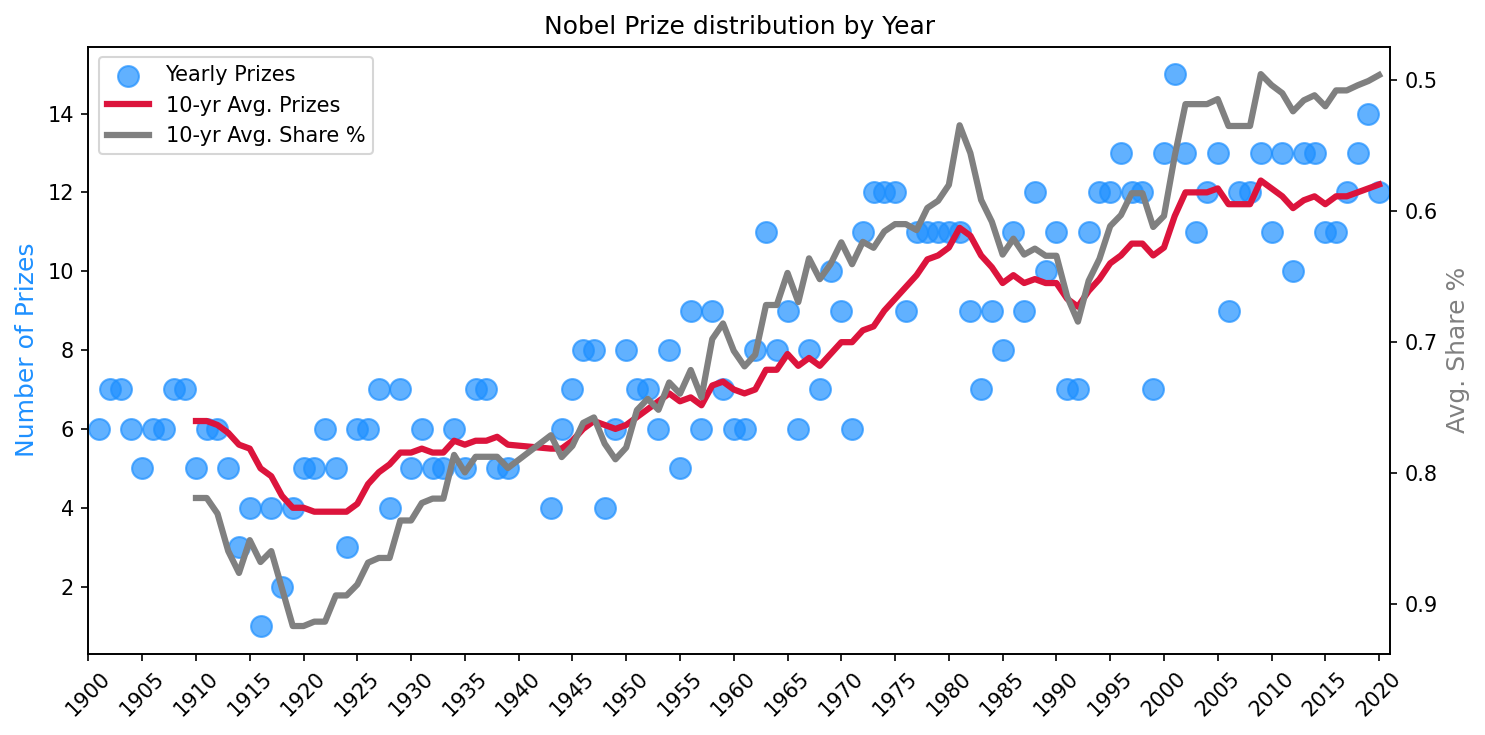

In [4]:
def gen_chart_yearly_noblel(in_df: pd.DataFrame) -> None:
    awards_per_year = in_df.groupby('year').count().prize
    moving_avg = awards_per_year.rolling(window=10).mean()

    yearly_share = in_df.groupby('year').agg({'share_pct': 'mean'})
    share_moving_avg = yearly_share.rolling(window=10).mean()

    plt.figure(figsize=(10, 5), dpi=150)
    plt.title(f'Nobel Prize distribution by Year')
    plt.xticks(
        ticks=np.arange(
            awards_per_year.index.min() - 1, 
            awards_per_year.index.max() + 1, 
            step=5
        ),
        fontsize=10,
        rotation=45
    )
    plt.yticks(fontsize=10)

    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.set_xlim(awards_per_year.index.min() -1, awards_per_year.index.max() + 1)
    ax1.set_ylabel('Number of Prizes', color='dodgerblue', fontsize=12)
    ax2.set_ylabel('Avg. Share %', color='grey', fontsize=12)
    ax2.invert_yaxis()

    ax1.scatter(
        x=awards_per_year.index,
        y=awards_per_year.values,
        c='dodgerblue',
        alpha=0.7,
        s=100,
        label='Yearly Prizes'
    )
    ax1.plot(
        awards_per_year.index,
        moving_avg.values,
        c='crimson',
        linewidth=3,
        label='10-yr Avg. Prizes'
    )

    ax2.plot(
        awards_per_year.index,
        share_moving_avg.values,
        c='grey',
        linewidth=3,
        label='10-yr Avg. Share %'
    )

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    setup_logging()

    in_df = fetch_df('input-79.csv')
    in_df = conv_df_dtype(in_df)

    gen_chart_yearly_noblel(in_df)
    

# A Choropleth Map and the Countries with the Most Prizes

In [5]:
def gen_bar_fig_top20(in_df: pd.DataFrame) -> None:
    top20_countries = in_df.groupby(by='birth_country_current').agg({'prize': 'count'}).sort_values(by='prize', ascending=False).head(20).reset_index()
    
    cat_country = in_df.groupby(
        by=['birth_country_current', 'category'], 
        as_index=False
    ).agg({'prize': 'count'}).sort_values(
        by='prize', 
        ascending=False
    )
    cat_country = cat_country[cat_country.birth_country_current.isin(top20_countries.birth_country_current)]

    merged_df = pd.merge(cat_country, top20_countries, on='birth_country_current')
    merged_df.columns = ['birth_country_current', 'category', 'cat_prize', 'total_prize']
    merged_df = merged_df.sort_values(by='total_prize')
    
    top20_bar_fig = px.bar(
        data_frame=merged_df,
        x='cat_prize',
        y='birth_country_current',
        orientation='h',
        color='category',
        title='Top 20 Countries by Number of Prizes',
        height=len(merged_df['birth_country_current'].unique()) * 50
    )
    top20_bar_fig.update_layout(
        xaxis_title='Number of Prizes', 
        yaxis_title='Country',
        yaxis={'categoryorder': 'total ascending'}
    )
    top20_bar_fig.show()


def gen_fig_map(in_df: pd.DataFrame) -> None:
    countrywise_distribution = in_df.groupby(
        by=['birth_country_current', 'ISO']
    ).agg({'prize': 'count'}).sort_values(
        by='prize', 
        ascending=False
    ).reset_index()
    world_map_fig = px.choropleth(
        data_frame=countrywise_distribution,
        locations='ISO',
        color='prize',
        hover_name='birth_country_current',
        color_continuous_scale=px.colors.sequential.matter
    )
    world_map_fig.update_layout(coloraxis_showscale=True)
    world_map_fig.show()


def gen_fig_prize_by_country_over_time(in_df: pd.DataFrame) -> None:
    yearly_country_df = in_df.groupby(
        by=['birth_country_current', 'year']
    ).size().reset_index(
        name='yearly_prize_count'
    )
    yearly_country_df['cumulative_prize'] = yearly_country_df.groupby(by='birth_country_current')['yearly_prize_count'].cumsum()

    line_chart = px.line(
        data_frame=yearly_country_df,
        x='year',
        y='cumulative_prize',
        color='birth_country_current',
        hover_name='birth_country_current',
        title='Cumulative Nobel Prizes by Country Over Time',
        labels={
            'year': 'Year',
            'cumulative_prize': 'Cumulative Number of Prizes',
            'birth_country_current': 'Country'
        }
    )
    line_chart.update_layout(
        xaxis_title='Year',
        yaxis_title='Number of Prizes'
    )
    line_chart.show()


if __name__ == '__main__':
    setup_logging()

    in_df = fetch_df('input-79.csv')
    in_df = conv_df_dtype(in_df)

    # gen_bar_fig_top20(in_df)
    # gen_fig_map(in_df)
    gen_fig_prize_by_country_over_time(in_df)


# Create Sunburst Charts for a Detailed Regional Breakdown of Research Locations

In [6]:
def gen_fig_top20_org(in_df: pd.DataFrame) -> None:
    org_df = in_df.groupby(by='organization_name', as_index=False).agg({'prize': 'count'}).sort_values(by='prize', ascending=False).head(20)

    org_bar_fig = px.bar(
        data_frame=org_df,
        x='prize',
        y='organization_name',
        orientation='h',
        color='prize',
        color_continuous_scale=px.colors.sequential.haline,
        title='Top 20 organization noble distribution',
        height=len(org_df['organization_name'].unique()) * 30,
        labels={'prize': 'Number of Prizes', 'organization_name': 'Institution'}
    )
    org_bar_fig.update_layout(
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'}
    )
    org_bar_fig.show()


def gen_fig_org_city(in_df: pd.DataFrame) -> None:
    org_city_df = in_df.groupby(by='organization_city', as_index=False).agg({'prize': 'count'}).sort_values(by='prize', ascending=False).head(20)
    org_city_bar_fig = px.bar(
        data_frame=org_city_df,
        x='prize',
        y='organization_city',
        orientation='h',
        color='prize',
        color_continuous_scale=px.colors.sequential.Plasma,
        title='Which Cities Do the Most Research?',
        height=len(org_city_df['organization_city'].unique()) * 30,
        labels={'prize': 'Number of Prizes', 'organization_city': 'City'}
    )
    org_city_bar_fig.update_layout(
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'}
    )
    org_city_bar_fig.show()


def gen_fig_birth_city(in_df: pd.DataFrame) -> None:
    top20_laurate_birth_city = in_df.groupby(by='birth_city', as_index=False).agg({'prize': 'count'}).sort_values(by='prize', ascending=False).head(20)
    # print(top20_laurate_birth_city)
    laurate_birth_city_bar_fig = px.bar(
        data_frame=top20_laurate_birth_city,
        x='prize',
        y='birth_city',
        orientation='h',
        color='prize',
        color_continuous_scale=px.colors.sequential.Plasma,
        title='Where were the Nobel laurates born?',
        height=len(top20_laurate_birth_city['birth_city'].unique()) * 30,
        labels={'prize': 'Number of Prizes', 'birth_city': 'Birth City'}
    )
    laurate_birth_city_bar_fig.update_layout(
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'}
    )
    laurate_birth_city_bar_fig.show()


def gen_sunburst(in_df: pd.DataFrame) -> None:
    country_city_org = in_df.groupby(
        by=['organization_country', 'organization_city', 'organization_name'],
        as_index=False
        ).agg({'prize': 'count'}).sort_values(by='prize', ascending=False)
    # print(country_city_org)
    burst = px.sunburst(
        data_frame=country_city_org,
        path=[
            'organization_country',
            'organization_city',
            'organization_name',
        ],
        values='prize',
        title='Where do discoveries take place?'
    )
    burst.update_layout(
        xaxis_title='Number of Prizes',
        yaxis_title='City'
    )
    burst.show()


if __name__ == '__main__':
    setup_logging()

    in_df = fetch_df('input-79.csv')
    in_df = conv_df_dtype(in_df)

    # gen_fig_top20_org(in_df)    
    # gen_fig_org_city(in_df)
    # gen_fig_birth_city(in_df)
    gen_sunburst(in_df)

    



# Unearthing Patterns in the Laureate Age at the Time of the Award

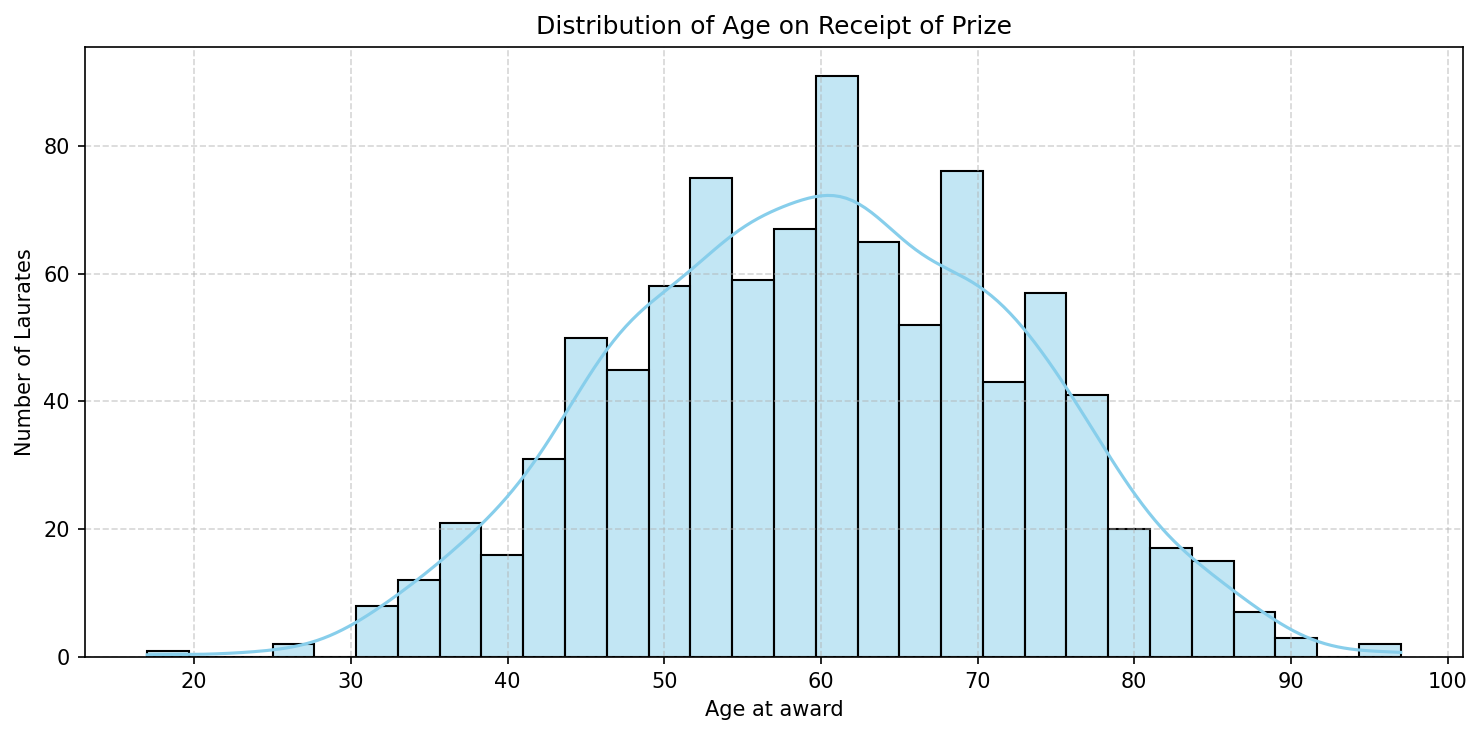

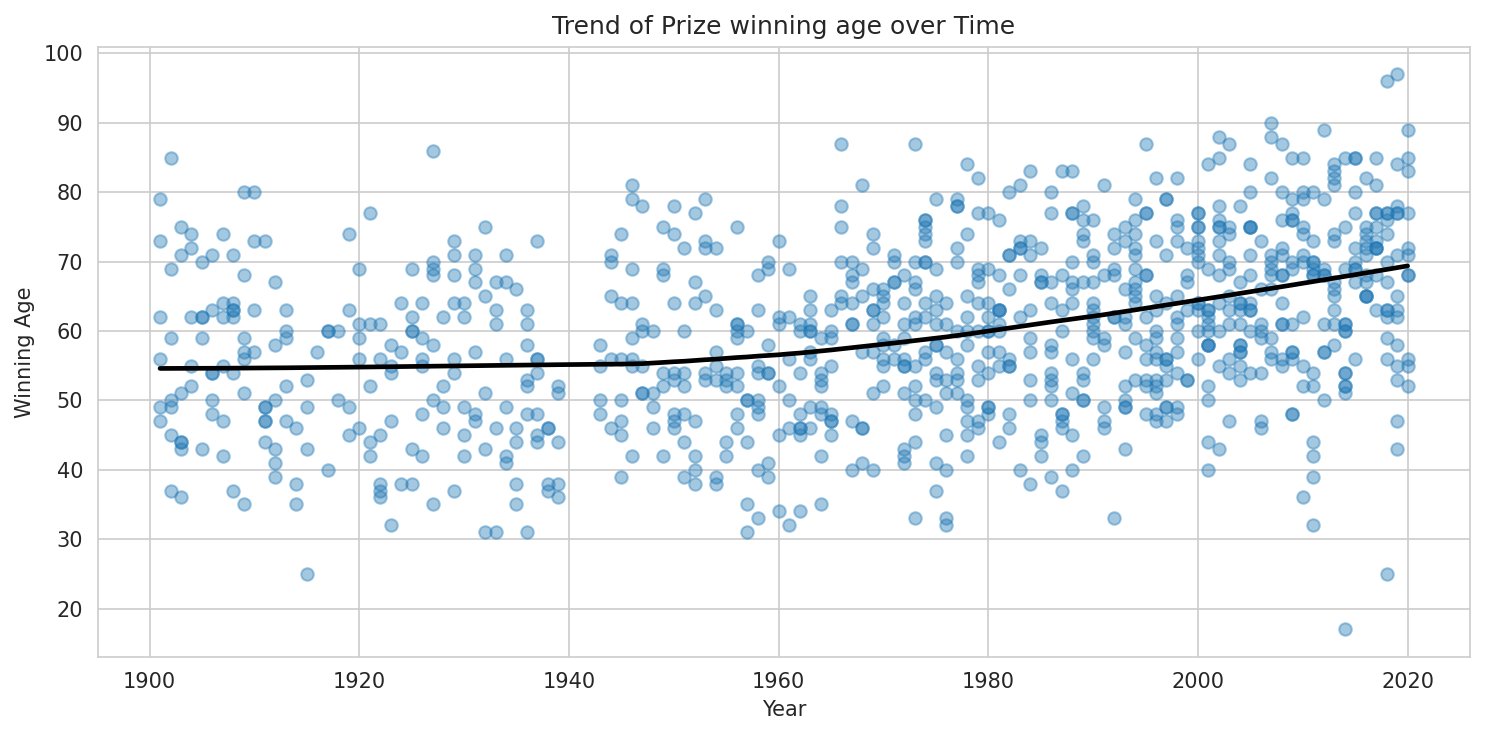

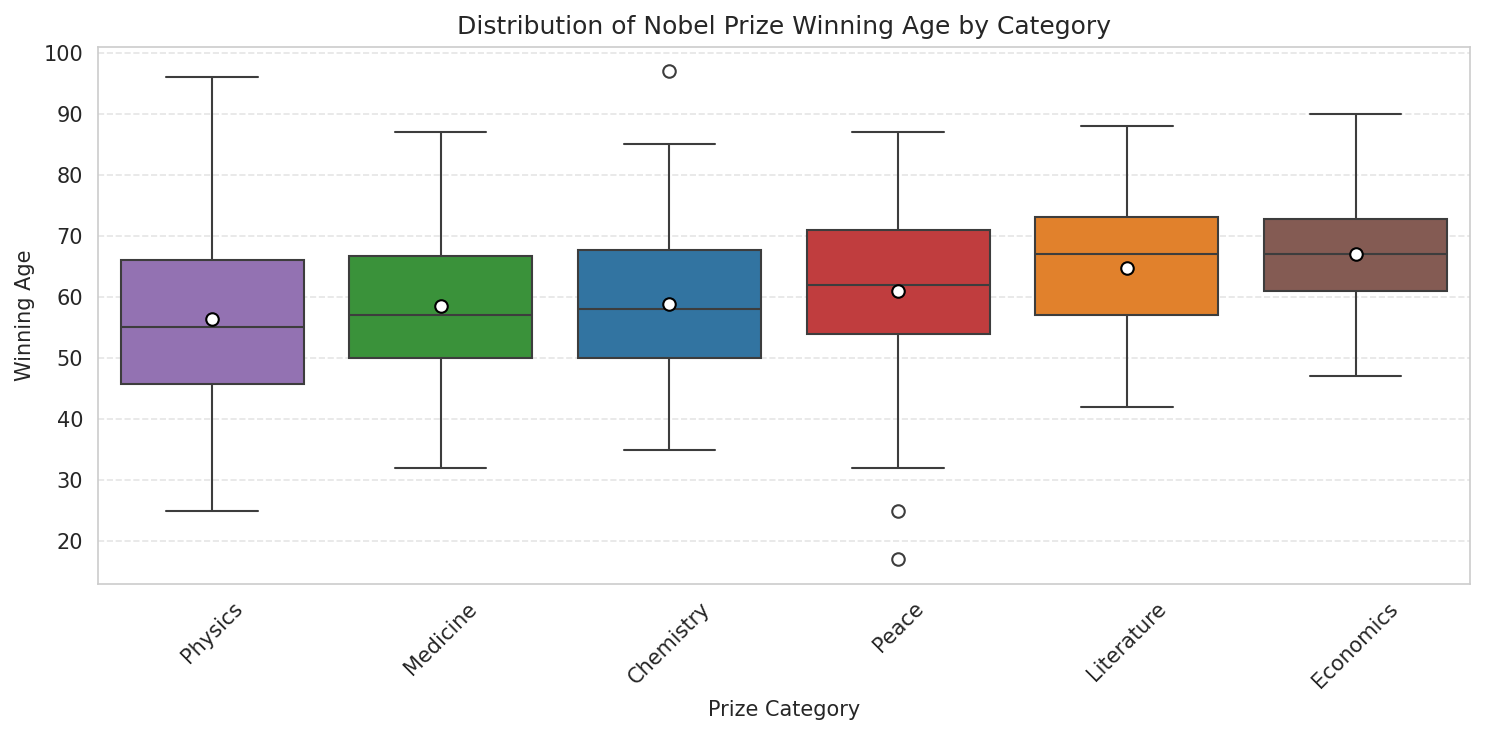

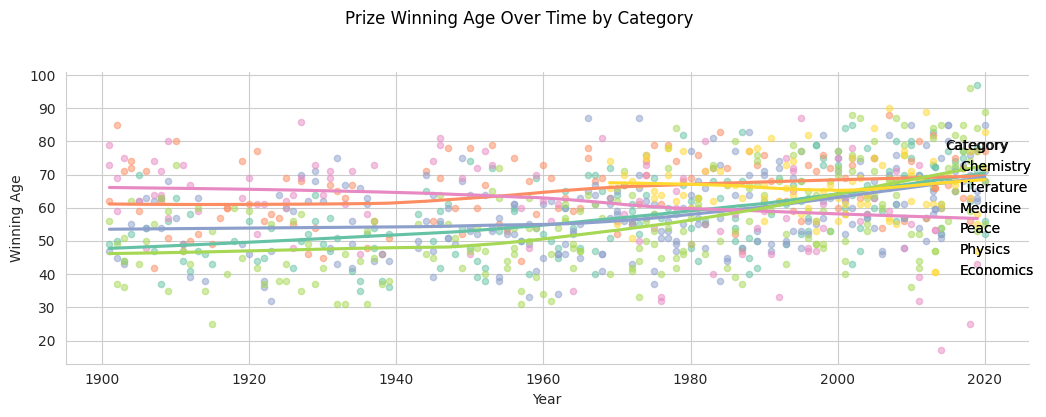

In [26]:
def explore_winning_age(in_df: pd.DataFrame) -> None:
    display(in_df.nlargest(n=1, columns='winning_age'))
    display(in_df.nsmallest(n=1, columns='winning_age'))

    print(f'Winning age info: {in_df.winning_age.describe()}')


def gen_fig_winning_age(in_df: pd.DataFrame) -> None:
    plt.figure(
        figsize=(10, 5),
        dpi=150
    )
    sns.histplot(
        data=in_df,
        x=in_df.winning_age,
        bins=30,
        kde=True,
        color='skyblue'
    )
    plt.xlabel('Age at award')
    plt.ylabel('Number of Laurates')
    plt.title('Distribution of Age on Receipt of Prize')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def gen_fig_winning_age_over_time(in_df: pd.DataFrame) -> None:
    plt.figure(
        figsize=(10, 5),
        dpi=150
    )
    with sns.axes_style('whitegrid'):
        sns.regplot(
            data=in_df,
            x='year',
            y='winning_age',
            lowess=True,
            scatter_kws= {'alpha': 0.4},
            line_kws={'color': 'black'}
        )
    plt.xlabel('Year')
    plt.ylabel('Winning Age')
    plt.title('Trend of Prize winning age over Time')
    plt.tight_layout()
    plt.show()


def gen_plt_agediff_cat(in_df: pd.DataFrame) -> None:
    # sort categories by median winning age
    ordered_cats = in_df.groupby('category')['winning_age'].median().sort_values().index

    plt.figure(
        figsize=(10, 5),
        dpi=150
    )
    with sns.axes_style('whitegrid'):
        sns.boxplot(
            data=in_df,
            x='category',
            y='winning_age',
            order=ordered_cats,
            hue='category',
            showmeans=True, 
            meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
        )
    plt.title('Distribution of Nobel Prize Winning Age by Category')
    plt.xlabel('Prize Category')
    plt.ylabel('Winning Age')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def gen_plt_age_cat_over_time(in_df: pd.DataFrame) -> None:
    with sns.axes_style('whitegrid'):
        g = sns.lmplot(
            data=in_df,
            x='year',
            y='winning_age',
            hue='category',
            lowess=True,
            height=4,
            aspect=2,
            scatter_kws={'alpha': 0.5, 's': 20},
            palette='Set2'
        )
    g.set_axis_labels('Year', 'Winning Age')
    g.fig.suptitle('Prize Winning Age Over Time by Category', y=1.03)
    g.add_legend(title='Category')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    setup_logging()

    in_df = fetch_df('input-79.csv')
    in_df = conv_df_dtype(in_df)

    in_df['winning_age'] = in_df.year - in_df.birth_date.dt.year

    # explore_winning_age(in_df)
    gen_fig_winning_age(in_df)
    gen_fig_winning_age_over_time(in_df)
    gen_plt_agediff_cat(in_df)
    gen_plt_age_cat_over_time(in_df)